# <span style="color:darkred">Data extract, manipulation and visualization</span>
Developer: Henriette Steenhoff



### <span style="color:darkred">Providers of data and recipients of result</span>
#### Jesper Bo Sembach, Niels Beuschau
*Master Thesis in Internet Security and Ransomware Detection*<br></br>
The Technical University of Denmark (DTU), June 2017

#### <span style="color:darkred">Purpose</span>
This code was made for extracting important data for analysis and results for the Master Thesis of Jesper Bo Sembach and Niels Beuschau. The code extracts and manipulates data from their test environment into correct data structures for visualization and performance analysis. 

----

### <span style="color:darkred">The code</span>

#### <span style="color:darkred">Functions</span>
For code ledgibility

In [138]:
# -------------------------------------------------------------------------------- #
# The Technical University of Denmark, June 2017
# Developer: Henriette Steenhoff, s134869
# Purpose:   Analysis and visualization of performance measures for Master Thesis of 
#            Jesper Bo Sembach and Niels Beuschau
# -------------------------------------------------------------------------------- #

# IMPORTS
import re
import json
# Only importing needed modules to avoid os.open being chosen instead of built-in open
from os import path, chdir, makedirs, listdir, getcwd 
import time
from datetime import datetime 
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib as plt
%matplotlib inline

import plotly
import plotly.plotly as py
from IPython.display import Image 
import plotly.graph_objs as go
# API access to plotting tools
# Will need access to perform plotting
#plotly.tools.set_credentials_file(username=, api_key =)
plotly.tools.set_credentials_file(username='frksteenhoff2', api_key ='duu8hsfRmuI5rF2EU8o5')

basePath    = "C:/Users/frksteenhoff/Documents/GitHub/MSc-Sembach-Beuschau_Jun2017/"
pathToPlots = basePath + "Visualization"

# -------------------------------------------------------------------------------- #
# HELPER FUNCTIONS FOR THE VISUALIZATION SCRIPT BELOW
# -------------------------------------------------------------------------------- #

# Function creating correct layout style for each type of plot 
def setLayoutOptions(headTitle, ytitle):
    layout= go.Layout(
            title= headTitle.upper(),
            hovermode= 'closest',
            xaxis= dict(
                title= 'Time (0.5 second interval)',
                ticklen= 5,
                zeroline= True,
                gridwidth= 2,
            ),
            yaxis=dict(
                title= ytitle,
                ticklen= 5,
                gridwidth= 2,
            ),
            showlegend= False
    )
    return layout


# Remove all occurences of AppData paths from a given list of paths
def removeAppData(lst):
    outFile = []
    for f in lst:
        current_file = f.split('*')[0]
        pattern = re.compile('.*AppData.*')
        if not pattern.match(current_file):
            outFile.append(f)
    return outFile


# Split information from txt file in title and data
def splitTitleAndFiles(line, lineNumber):
    temp = []
    separteValues = []
    
    temp = line.strip('\n')
    titleAndList = temp.split(';')
    title = titleAndList[0]
    #print title
        
    separateValues = titleAndList[1].split('?')
     
    if lineNumber in range(11,16):
        values = [val.replace(',','.') for val in separateValues]
    else:
        values = separateValues
    
    return title, values

    
# Create cpu, ram, hdd, handle and thread count plots
def createPerformancePlots(title, listValues, lineNumber, filename, folder, pathToPlots, pathToFiles):
    # NOTE! The plotting is done by using the plotly module.
    # The API connection might be lost and the function would need to be run anew. 
    mode = 'lines'
    
    # Set plotting marker
    # Commented out intentionally
    #if lineNumber == 11:
    #    mode = 'markers'
    #else:
    #    mode = 'lines'
        
    trace1 = go.Scatter(
        x = range(0,len(listValues)),
        y = listValues, 
        mode = mode,
        marker = dict(
            size = 3
        )
    )    
    
    # Choose right values for plotting cpu, ram or hdd, handle and thread count
    if lineNumber == 11:
        layout = setLayoutOptions(title, 'Percent')
    if lineNumber == 12:
        layout = setLayoutOptions(title, 'MB')
    elif lineNumber == 13:
        layout = setLayoutOptions(title, 'Speed - missing unit')
    elif lineNumber == 14:
        layout = setLayoutOptions(title, 'Number of handles')
    elif lineNumber == 15:
        layout = setLayoutOptions(title, 'Number of threads')
    else:    
        layout = setLayoutOptions(title, 'Byte')

    data = [trace1]
    fig  = go.Figure(data=data, layout=layout)
    
    # Create folder for plots if not exists
    dir_name = pathToPlots + "/" + folder
    if not path.exists(dir_name):
        makedirs(dir_name)
    chdir(dir_name)
    
    # Save image to file
    py.image.save_as(fig, filename=filename.strip('.txt') + "-"+ title + '.png')    
    chdir(pathToFiles)
    time.sleep(2) # Sleep added not to exhaust API
    
    
# ('File sizes over time', fileSizes, files, pathToPlots, pathToFiles)
def createFileSizePlots(title, size_list, filename, folder, plot_path, file_path):
    dir_name = plot_path + "/" + folder
    chdir(dir_name)
    
    plt.scatter(range(0,len(size_list)), size_list, '-o', alpha=0.5)
    plt.title(title)
    plt.xlabel('Byte')
    plt.ylabel('Time (0.5 second interval)')
    plt.savefig(title + '-size.png')
    chdir(file_path)

# Extract path to file, removing redundant backslashes w. regex
def findFilePath(fileList, splitCrit):
    fileNames = []
    
    for f in fileList:
        pathStr = f.split(splitCrit)[0]
        fileNames.append(re.sub(r'\D:\\{1,4}\w*\\{1,4}\w*\\{1,4}', '', pathStr))
    return fileNames

# Fetching file sizes from basline or test data
def getFileSizes(filename):
    sizeOfFiles = {}
    
    with open(filename, 'r') as f:
        paths = f.readlines()
    
    for lines in paths:
        values = lines.split('?')
        keyy = values[0].strip("C:\Users\Baseline\\")
        sizeOfFiles[keyy] = values[1]                                   
    return sizeOfFiles

                                   
# Creating a ist of the file sizes found for baseline, or test data
# Here assuming that all files can be found in size_dict (from baselinedata.txt)                           
def createFileSizeList(files, size_dict):
    sizeList = []
    for f in files:
        # Strip f of excess backslashes
        print f
        keyy = re.sub(r'\+','_', f)
        print keyy
        key2 = re.sub(r'_', '', f)
        print key2
        sizeList.append(size_dict[key2])
    return sizeList
                   
# Creating box plots and saving result to file
def createBoxplot(plottingValues, labels, filename, plotTitle, xlabel, ylabel):
    # Creating figure and setting plotting type
    pl.figure(figsize=(10,7))
    pl.boxplot(plottingValues)

    # Values - for ledgibility
    #pl.title(plotTitle)
    pl.xlabel(xlabel)
    pl.ylabel(ylabel)
    # Label values
    pl.xticks(range(1,len(labels)+1), labels)
    pl.savefig(filename + '.png')

def createStackedBarPlot2Values(data1, data2, labels, filename, color):
    n = len(labels)
    fig, ax = pl.subplots(figsize=(10,7))
    bar_locations = np.arange(n)
    ax.bar(bar_locations, data1)
    ax.bar(bar_locations, data2, bottom=data1, color=color)
    
    # Styling, labels and descriptions
    ax.set_xticks(np.arange(n) + 0.85 / 2)
    ax.set_xticklabels(labels)
    ax.legend(['Detection method reacted','No reaction'])
    pl.title('Detection success rate')
    pl.xlabel('Detection method')
    pl.ylabel('Frequency')
    
    chdir(pathToPlots)
    pl.savefig(filename + '.png')

# Get time between start and detection and detection and shutdown of ransomwares
def getTimeDeltas(startTime, detectionTime, shutdownTime):
    date_format = "%d-%m-%Y %H:%M:%S.%f"
    # Getting time values, creating date on correct date format
    started      = datetime.strptime(detectionTime[0], date_format)
    detected     = datetime.strptime(detectionTime[0], date_format)
    shutdown     = datetime.strptime(shutdownTime[0], date_format)
    # Calculate time from start -> detection and detection -> shutdown
    startDetTime = detected - started  
    detShutTime  = shutdown - detected
    return startDetTime, detShutTime

#### <span style="color:darkred">Read all files in each folder of "Speciale"</span>
All data from folder ``Speciale``, found [here](www.github.com/frksteenhoff/MSc-Niels-Jesper-June2017/) on Github will, be used for extracting visualizations. The visualizations will be placed in a separate folder with the same structure as the ``Speciale`` folder, named ``Visualization``.

Current folder: hp1
Current folder: hp2
Current folder: hp5
Current folder: hp10
Current folder: sh3
Current folder: sh5
Current folder: sh10
Current folder: sh15

All files read


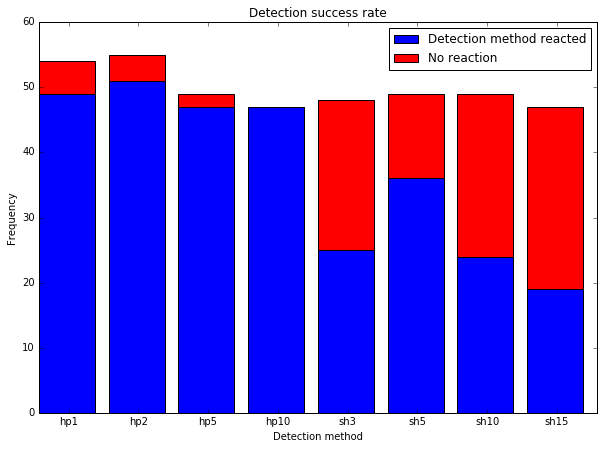

In [142]:
# -------------------------------------------------------------------------------- #
# The actual visualization script
# -------------------------------------------------------------------------------- #
# Basic inits
# Note! When creating boxlpots using line 3 and 20-22, the following slice is used: folders[1:]
# The code can be run in modules by adding the "and False" statement to the if-statements 
# the user wish to exclude. Below only the last if is run

folders = ['baseline', 'hp1', 'hp2','hp5', 'hp10', 'sh3', 'sh5', 'sh10', 'sh15']
successShutdown     = 0
lineNumber          = 0

boxplotDel         = [] # 2-d list for boxplot of deleted files
boxplotNew         = [] # 2-d list for boxplot of new files
obsMon             = [] # obsmon observations
fileSizes          = [] # list for file sizes (not implemented fully)
delLst             = [] # list of count of deleted files 
newLst             = [] # list of count of new files
failedShutdownCnt  = [] # list of number of failed shutdowns
successShutdownCnt = [] # list of shut downs
startDetLst        = [] # list of timedeltas from start to detection
detShutLst         = [] # list of timedeltas from detection to shutdown


chdir(basePath)
baselineData = getFileSizes('BaselineFileData.txt')

# For all folders in Speciale, access each folder and  'do something'
for folder in folders[1:]:
    pathToFiles   = basePath + "Speciale/" + folder 
    chdir(pathToFiles)
    selectedFiles = [file for file in listdir('.') if file.endswith('.txt')]
    print "Current folder: " + folder
    
    # For each file in current folder, read content 
    for files in selectedFiles:
        #print files
        # Read each line and split content into dictionary
        with open(files, 'r') as f:
            content = f.readlines()
        
        for lines in content:
            # Create list of values for boxplot of number of deleted files
            if lineNumber == 8  and False:
                delFile, delCnt = splitTitleAndFiles(lines, lineNumber)
                delLst.append(int(delCnt[0]))
        
            # Create list of values for boxplot of number of new files
            elif lineNumber == 9  and False:
                newFile, newCnt = splitTitleAndFiles(lines, lineNumber)
                newLst.append(int(newCnt[0]))
                
            # Data for cpu, ram, hdd, thread or handle count 
            elif lineNumber in range(11,16) and False:
                # Get attribute and list of values
                title, listValues = splitTitleAndFiles(lines, lineNumber)
                    
                # Create plots cpu, ram, hdd, handle and thread count
                createPerformancePlots(title, listValues, lineNumber, files, folder, pathToPlots, pathToFiles)
               
            # fileMonObservations
            elif (lineNumber == 19) and False:
                # Get attribute and list of values
                title, listValues = splitTitleAndFiles(lines, lineNumber)
                    
                # Extract all files not in folder AppData
                obsMon = removeAppData(listValues)
                filePaths = findFilePath(obsMon, '*')
                fileSizes = createFileSizeList(filePaths, baselineData)
                createFileSizePlots('File sizes over time', fileSizes, 0, files, pathToPlots, pathToFiles)
            
            # Creating datastructures for boxplots of performance on shut-down
            elif lineNumber == 3 or lineNumber ==  20 or lineNumber ==  21 or lineNumber ==  22:
                # Start time
                if lineNumber == 3:
                    lineName, startTime = splitTitleAndFiles(lines, lineNumber)
                
                # Name of shutdown ransomware(s)
                elif lineNumber == 20:
                    lineName, shutdownLst = splitTitleAndFiles(lines, lineNumber)
                    
                # Time of detection
                elif lineNumber == 21:
                    lineName, detectionTime = splitTitleAndFiles(lines, lineNumber)                    
                    
                # Time of shutdown
                else:
                    lineName, shutdownTime = splitTitleAndFiles(lines, lineNumber)
                    
            ## Nothing implemented using sepcific information in file 
            #else:
            #    print ''#lines.strip('\n').split(';')[0].ljust(24), "nothing implemented"
            lineNumber += 1
        
        # Find number of ransomwares that do shut processes down.
        # '' indicates empty list
        if len(shutdownLst) >= 1 and shutdownLst[0] != '':
            successShutdown += 1
        
        # Reset variables
        lineNumber = 0
        fileSizes = []
        
    # Calculate time from start -> detection and detection -> shutdown
    #startDetTime, detShutTime = getTimeDeltas()
       
    # Adding time differences to lists
    #startDetLst.append(startDetTime)
    #detShutLst.append(detShutTime)    
    
    # Creating 2-d list for boxplots time
    #boxStartDet.append(startDetLst)
    #boxDetShut.append(detShutLst)
    #startDetLst = []
    #detShutLst  = []
        
    # Append to lists of fail/success for boxplot
    failedShutdownCnt.append(len(selectedFiles) - successShutdown)
    successShutdownCnt.append(successShutdown)
    successShutdown = 0
    
    # Create 2-d list for boxplots - new and deleted files
    #boxplotDel.append(delLst)    
    #boxplotNew.append(newLst)
    #delLst = []
    #newLst = []
    
print "\nAll files read"

# Creating and saving boxplots for deleted and new files
#chdir(pathToPlots)
#createBoxplot(boxplotDel, folders, 'delFiles', 'Boxplot for deleted files', 'Distribution', 'Value')
#createBoxplot(boxplotNew, folders, 'newFiles', 'Boxplot for new files', 'Distribution', 'Value')
#print "Box plots created:"

# Creating and saving stacked bar plot for shutdown indication
createStackedBarPlot2Values(successShutdownCnt, failedShutdownCnt, folders[1:], 'shutdown', 'r')

# 

----
### Shortcut to simple styling tricks
``<span style="color:darkred"></span>``

In [131]:
# Creating correct date format
date_format = "%d-%m-%Y %H:%M:%S.%f"
detected = datetime.strptime(detectionTime[0], date_format)
shutdown = datetime.strptime(shutdownTime[0], date_format)

In [136]:
diff = detected - shutdown
#datetime.timedelta(0, 8, 562000)
#divmod(diff.days * 86400 + diff.seconds, 60)
#(0, 8)      # 0 minutes, 8 seconds
diff

datetime.timedelta(0, 0, 1000)

In [133]:
print times, timet
#print(diff.total_seconds() // 60)

DatetimeIndex(['2017-05-26 15:25:25.093000'], dtype='datetime64[ns]', freq=None) DatetimeIndex(['2017-05-26 15:25:25.092000'], dtype='datetime64[ns]', freq=None)


In [95]:
times

array([datetime.time(15, 25, 25, 92000)], dtype=object)